In [1]:
%config Completer.use_jedi = False

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import glob

Preprocess the index data

In [2]:
data_df = pd.concat([pd.read_csv(f, parse_dates=['Date'], index_col=['Date']) for f in glob.glob('../Data/Nifty/OHLC/*.csv',)], 
                    join='outer')

In [3]:
data_df.head()

,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
Date,,,,,,
2018-01-02,10477.55,10495.2,10404.65,10442.20,158092430,8665.47
2018-01-03,10482.65,10503.6,10429.55,10443.20,172516859,9541.60
2018-01-04,10469.40,10513.0,10441.45,10504.80,180257392,9561.95
2018-01-05,10534.25,10566.1,10520.10,10558.85,186469717,10306.22
2018-01-08,10591.70,10631.2,10588.55,10623.60,174181231,9907.27


#TODO check for missing data

#### Raw

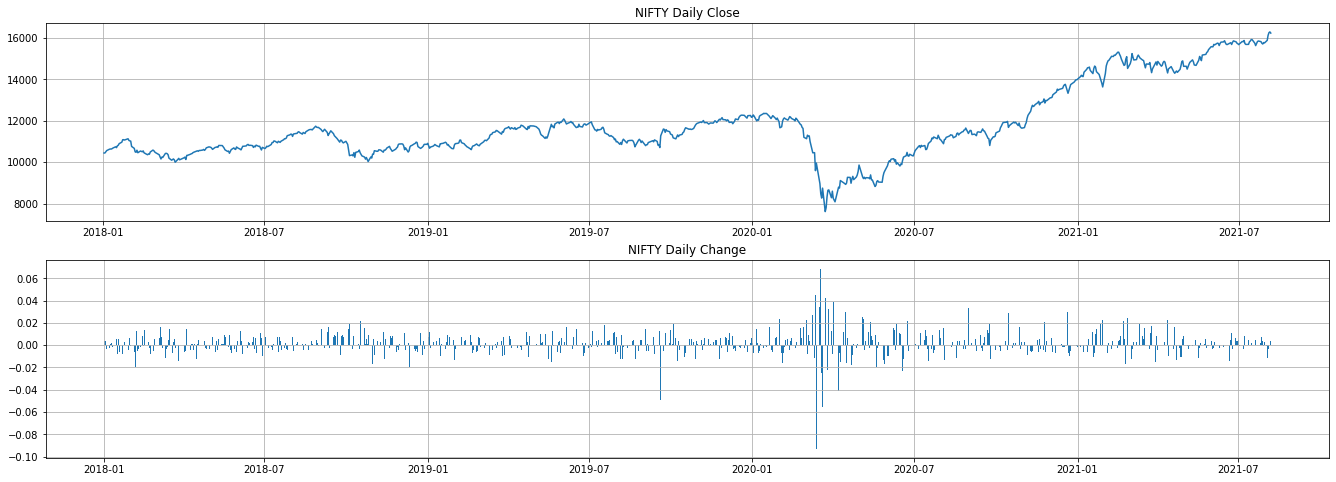

In [4]:
fig = plt.figure(figsize=(23,8))
ax = fig.add_subplot(211)
ax.plot(data_df.Close)
ax.grid()
ax.set_title('NIFTY Daily Close')
# fig = plt.figure(figsize=(23,5))
ax = fig.add_subplot(212)
ax.bar(data_df.index, (data_df.Open - data_df.Close)/data_df.Open)
ax.set_title('NIFTY Daily Change')
ax.grid()

#### Stationarized

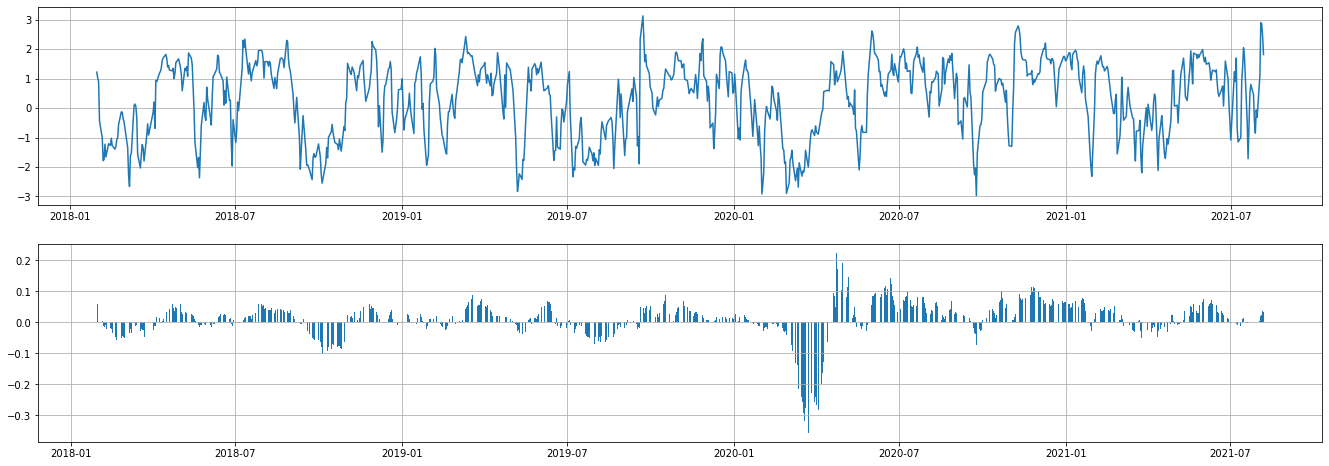

In [5]:
fig = plt.figure(figsize=(23,8))
ax = fig.add_subplot(211)
ax.plot(data_df.Close.rolling(20).apply(lambda x: (x[-1]-x.mean())/x.std()))
ax.grid()
ax = fig.add_subplot(212)
ax.bar(data_df.index, data_df.Close.rolling(20).apply(lambda x: (x[-1]-x[0])/x[0]))
# ax.bar(data_df.index, (data_df.Open - data_df.Close).rolling(20).apply(lambda x: (x[-1]-x.mean())/x.std()))
ax.grid()

Rate of Change Analysis

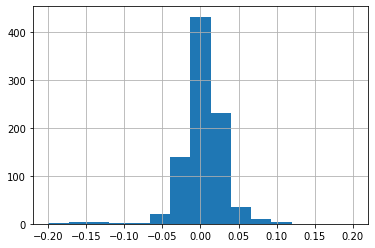

In [6]:
trade_days_left = 6 # used as window size
period_change = data_df.Close.rolling(trade_days_left).apply(lambda x: (x[-1]-x[0])/x[0]).dropna()
plt.hist(period_change, bins=15, range=(-0.2,0.2))
plt.grid()

In [7]:
period_change.mean()

0.002835623497297743

In [8]:
period_change.std()

0.028073065616504588

In [9]:
(period_change>0).sum()/len(period_change)

0.5740112994350283

In [10]:
(period_change<0).sum()/len(period_change)

0.42598870056497173

In [11]:
expected_change_neg_sigma = period_change.mean() - period_change.std()
prob_change_neg_sigma = (period_change<expected_change_neg_sigma).sum()/len(period_change)
print("%.3f probability of < %.2f%% change" %(prob_change_neg_sigma, expected_change_neg_sigma*100))

0.096 probability of < -2.52% change


In [12]:
expected_change_pos_sigma = period_change.mean() + period_change.std()
prob_change_pos_sigma = (period_change>expected_change_pos_sigma).sum()/len(period_change)
print("%.3f probability of > %.f%% change" %(prob_change_pos_sigma, expected_change_pos_sigma*100))

0.088 probability of > 3% change


In [13]:
expected_change = 0.01
prob_change = (period_change>expected_change).sum()/len(period_change)
print("%.3f probability of > %.f%% change" %(prob_change, expected_change*100))

0.388 probability of > 1% change


In [14]:
expected_change = -0.01
prob_change = (period_change<expected_change).sum()/len(period_change)
print("%.3f probability of < %.f%% change" %(prob_change, expected_change*100))

0.240 probability of < -1% change


In [15]:
import numpy as np

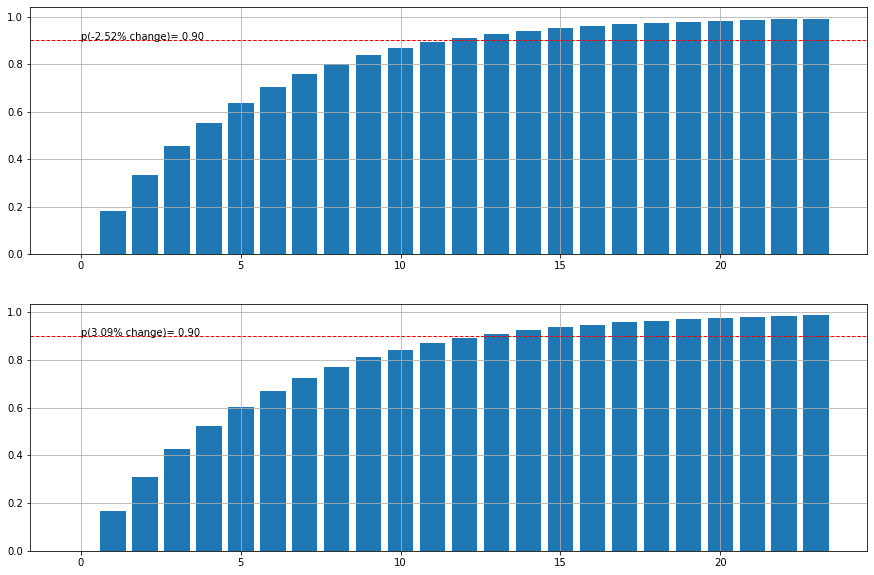

In [91]:
fig = plt.figure(figsize=(15,10))
threshold = 0.9
num_periods = range(24)

ax = fig.add_subplot(211)
ax.bar(num_periods,[1-(1-prob_change_neg_sigma)**(periods*2) for periods in num_periods])
plt.axhline(y=threshold, color='r', linewidth=1.0, linestyle='--')
plt.text(0,
         threshold,
         'p(%.2f%% change)= %.2f'%(expected_change_neg_sigma*100, threshold), 
         rotation=0)
ax.set_title('')
ax.grid()

ax = fig.add_subplot(212)
ax.bar(num_periods,[1-(1-prob_change_pos_sigma)**(periods*2) for periods in num_periods])
plt.axhline(y=threshold, color='r', linewidth=1.0, linestyle='--')
plt.text(0,
         threshold,
         'p(%.2f%% change)= %.2f'%(expected_change_pos_sigma*100, threshold), 
         rotation=0)
ax.set_title('')
ax.grid()

Options Chain Data

In [18]:
options_df = pd.concat([pd.read_csv(f, parse_dates=['Date'], index_col=['Date']) for f in glob.glob('../Data/Nifty/Options//*.csv',)], 
                    join='outer')

In [19]:
# Filter for latest data
options_df = options_df[options_df.index.max()==options_df.index]

In [20]:
options_df.columns

Index(['Symbol', 'Expiry', 'Option Type', 'Strike Price', 'Open', 'High',
       'Low', 'Close', 'LTP', 'Settle Price', 'No. of contracts',
       'Turnover in Lacs', 'Premium Turnover in Lacs', 'Open Int',
       'Change in OI', 'Underlying Value'],
      dtype='object')

In [21]:
options_df['Option Type'].unique()

array(['CE', 'PE'], dtype=object)

In [22]:
# Keep relevant Columns
options_df = options_df[['Symbol', 'Strike Price', 'Option Type', 'Expiry', 'Close','No. of contracts']]

In [23]:
options_df.shape

(170, 6)

In [24]:
sum(options_df['No. of contracts']>1000)

81

In [92]:
# Get rid of contracts which are not actively traded
options_df = options_df[options_df['No. of contracts']>1000]

In [28]:
# Set the last price
last_price = 16600

In [30]:
# Separate out Call and Put option
ce_df = options_df[options_df['Option Type']=='CE']
pe_df = options_df[options_df['Option Type']=='PE']

ce_df = ce_df.sort_values('Strike Price')
pe_df = pe_df.sort_values('Strike Price')

ce_change = ((ce_df['Strike Price'] - last_price)/last_price).values
pe_change = ((pe_df['Strike Price'] - last_price)/last_price).values

In [31]:
# Calculate Probabilty of out of the money call options expiring in the moeny
proba_atm_expiry_ce = np.zeros_like(ce_change)
for idx in range(len(ce_df)):
    proba_atm_expiry_ce[idx] = np.apply_along_axis(lambda x : x > ce_change[idx],
                                                axis=0,
                                                arr=period_change).mean()

strike_price_ce = ce_df['Strike Price'].values

In [37]:
# Calculate Probabilty of out of the money call options expiring in the moeny
proba_atm_expiry_pe = np.zeros_like(pe_change)
for idx in range(len(pe_df)):
    proba_atm_expiry_pe[idx] = np.apply_along_axis(lambda x : x < pe_change[idx],
                                                axis=0,
                                                arr=period_change).mean()

strike_price_pe = pe_df['Strike Price'].values

Text(0.5, 1.0, 'Cost = CE Price x Lot')

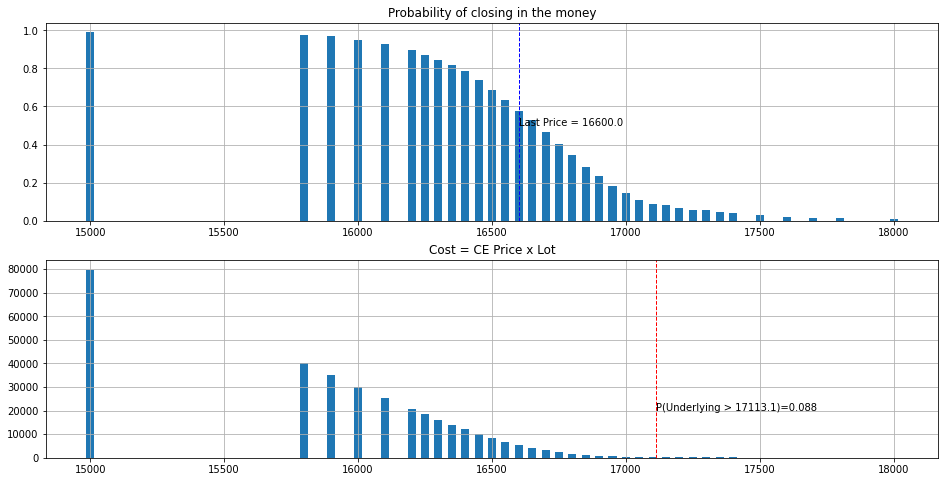

In [38]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(211)
ax.bar(x=strike_price_ce, height=proba_atm_expiry_ce, width=30)
ax.grid()
ax.set_title('Probability of closing in the money')
plt.axvline(x=last_price, color='b', linewidth=1.0, linestyle='--')
plt.text(last_price,
         0.5,
         'Last Price = %.1f'%last_price, 
         rotation=0)
ax = fig.add_subplot(212)
ax.bar(x=strike_price_ce, height=50*ce_df['Close'].values, width=30)
ax.grid(which='major')

sigma_high = last_price*(1+expected_change_pos_sigma)
plt.axvline(x=sigma_high, color='r', linewidth=1.0, linestyle='--')
plt.text(sigma_high,
         20000,
         'P(Underlying > %.1f)=%.3f'%(sigma_high,prob_change_pos_sigma), 
         rotation=0)

ax.set_title('Cost = CE Price x Lot')



Text(0.5, 1.0, 'Cost =PE Price x Lot')

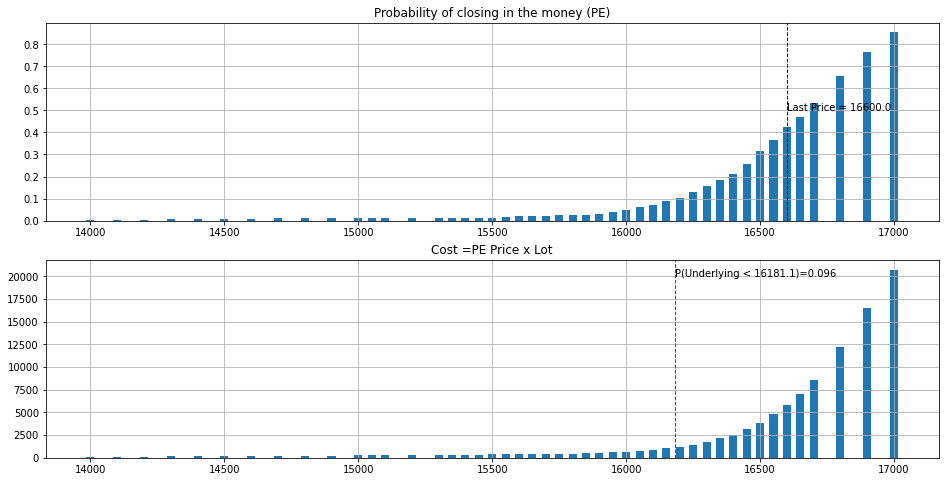

In [86]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(211)
ax.bar(x=strike_price_pe, height=proba_atm_expiry_pe, width=30)
ax.grid()
ax.set_title('Probability of closing in the money (PE)')
plt.axvline(x=last_price, color='b', linewidth=1.0, linestyle='--')
plt.text(last_price,
         0.5,
         'Last Price = %.1f'%last_price, 
         rotation=0)
ax = fig.add_subplot(212)
ax.bar(x=strike_price_pe, height=50*pe_df['Close'].values, width=30)
ax.grid(which='major')
sigma_low = last_price*(1+expected_change_neg_sigma)
plt.axvline(x=sigma_low, color='r', linewidth=1.0, linestyle='--')
plt.text(sigma_low,
         20000,
         'P(Underlying < %.1f)=%.3f'%(sigma_low,prob_change_neg_sigma), 
         rotation=0)

ax.set_title('Cost =PE Price x Lot')

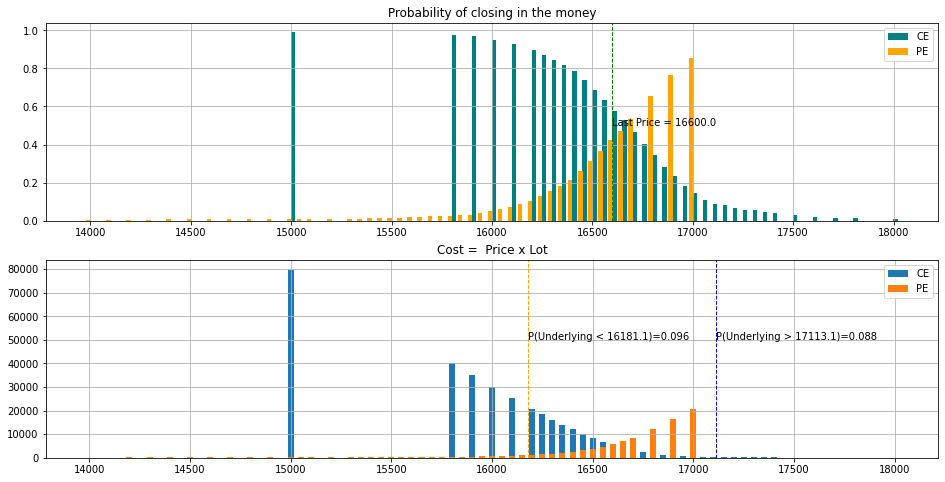

In [61]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(211)
ax.bar(x=strike_price_ce+10, height=proba_atm_expiry_ce, width=22, color='teal', align='center', label='CE')
ax.bar(x=strike_price_pe-10, height=proba_atm_expiry_pe, width=22, color='orange', align='center', label='PE')
ax.grid()
ax.set_title('Probability of closing in the money')
plt.axvline(x=last_price, color='g', linewidth=1.0, linestyle='--')
plt.text(last_price,
         0.5,
         'Last Price = %.1f'%last_price, 
         rotation=0)
ax.legend()

ax = fig.add_subplot(212)
ax.bar(x=strike_price_ce, height=50*ce_df['Close'].values, width=30, label='CE')
ax.bar(x=strike_price_pe, height=50*pe_df['Close'].values, width=30, label='PE')
ax.grid(which='major')

sigma_high = last_price*(1+expected_change_pos_sigma)
plt.axvline(x=sigma_high, color='blue', linewidth=1.0, linestyle='--')
plt.text(sigma_high,
         50000,
         'P(Underlying > %.1f)=%.3f'%(sigma_high,prob_change_pos_sigma), 
         rotation=0)

ax.set_title('Cost =  Price x Lot')

# ax = fig.add_subplot(313)
sigma_low = last_price*(1+expected_change_neg_sigma)
plt.axvline(x=sigma_low, color='orange', linewidth=1.0, linestyle='--')
plt.text(sigma_low,
         50000,
         'P(Underlying < %.1f)=%.3f'%(sigma_low,prob_change_neg_sigma), 
         rotation=0)
ax.legend()



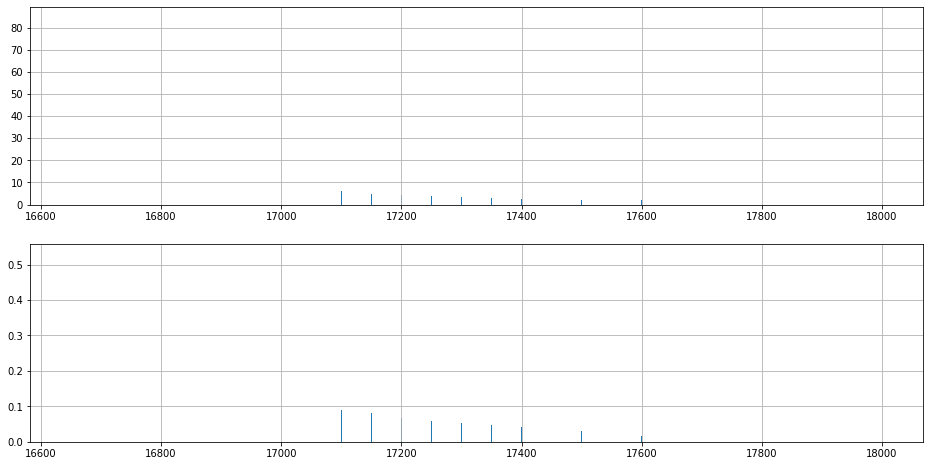

In [75]:
ce_mask = strike_price_ce>last_price
ce_price = ce_df.loc[ce_mask, 'Close'].values

fig = plt.figure(figsize=(16,8))


ax = fig.add_subplot(211)
ax.bar(strike_price_ce[ce_mask], ce_price)
ax.grid()
ax = fig.add_subplot(212)
ax.bar(strike_price_ce[ce_mask], proba_atm_expiry_ce[ce_mask])
ax.grid()



# Next
- Filter out OTM Options only
- Calculate Price/Probabilty
- Calculate potential returns
- Calculate Returns/Probability
- Combine all previous 3 into one metric
